<a href="https://colab.research.google.com/github/nicole-whitlock/games/blob/main/Distilbert_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import re
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
import seaborn as sns

from transformers import  DistilBertForSequenceClassification, TFDistilBertModel, DistilBertTokenizer, TFDistilBertForSequenceClassification
import numpy as np

In [5]:
    import torch

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

In [10]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [8]:
df = pd.read_csv('/content/english_reviews.csv')


In [9]:
df.shape

(1480220, 9)

In [20]:
# Create 3 sentiment categories
df['sentiment'] = np.where(
    df['score'] >= 70, 'positive',
    np.where(df['score'] <= 40, 'negative', 'neutral')
)

In [21]:
def clean_whitespace(text):
    # Remove leading/trailing spaces and collapse multiple spaces into one
    return re.sub(r'\s+', ' ', text.strip())

df['quote'] = df['quote'].apply(clean_whitespace)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [16]:
MAX_LEN = 128

def tokenize_optimized(data, max_len=MAX_LEN, batch_size=1000):
    input_ids_list = []
    attention_mask_list = []

    # Process in batches with progress bar
    for i in tqdm(range(0, len(data), batch_size)):
        batch = data[i:i + batch_size]
        encoded = tokenizer.batch_encode_plus(
            batch,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )

        input_ids_list.append(encoded['input_ids'].numpy())
        attention_mask_list.append(encoded['attention_mask'].numpy())

    # Concatenate batches
    input_ids = np.vstack(input_ids_list)
    attention_mask = np.vstack(attention_mask_list)

    return input_ids, attention_mask

In [17]:
data_quotes = df['quote'].tolist()
data_sentiments = df['sentiment'].tolist()

In [18]:
train_quotes, test_quotes, train_scores, test_scores = train_test_split(
    data_quotes, data_sentiments, test_size= 0.2, random_state = 42)
    # stratify=scores)


train_quotes, val_quotes, train_scores, val_scores = train_test_split(
    train_quotes, train_scores, test_size= 0.2, random_state = 42)
    # stratify=scores)

In [ ]:
input_ids,attention_mask = tokenize_optimized(train_quotes,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize_optimized(val_quotes,max_len = MAX_LEN)

In [27]:
sentiment_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Create a function to apply the mapping
def map_sentiment(sentiment):
    return sentiment_mapping.get(sentiment)

# Apply the mapping to your labels
train_labels = np.array([map_sentiment(sentiment) for sentiment in train_scores])
val_labels = np.array([map_sentiment(sentiment) for sentiment in val_scores])
test_labels = np.array([map_sentiment(sentiment) for sentiment in test_scores])

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': input_ids, 'attention_mask': attention_mask},
    train_labels
))
train_dataset = train_dataset.shuffle(100).batch(16)

In [29]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_input_ids, 'attention_mask': val_attention_mask},
    val_labels
))
val_dataset = val_dataset.batch(16)

In [30]:
class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Call the TFDistilBertModel within the call method
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, return_dict=True)
        return bert_output["last_hidden_state"]

# Create model function
def create_model(bert_model, max_len=MAX_LEN, num_classes=3):
    # Define inputs
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name='attention_mask')

    # BERT layer
    bert_output = DistilBertLayer(bert_model)([input_ids, attention_masks])

    # Global average pooling
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(bert_output)

    #Ddropout for regularization
    dropout = tf.keras.layers.Dropout(0.3)(pooled_output)

    # Output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [31]:
base_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model = create_model(base_model)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=2,
        restore_best_weights=True)]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
59209/59209 [==============================] - 2055s 34ms/step - loss: 0.3759 - accuracy: 0.8513 - val_loss: 0.3457 - val_accuracy: 0.8645
Epoch 2/10
59209/59209 [==============================] - 1998s 34ms/step - loss: 0.3137 - accuracy: 0.8767 - val_loss: 0.3528 - val_accuracy: 0.8651
Epoch 3/10
59209/59209 [==============================] - 1996s 34ms/step - loss: 0.2696 - accuracy: 0.8953 - val_loss: 0.3732 - val_accuracy: 0.8622
Epoch 4/10
59209/59209 [==============================] - 1995s 34ms/step - loss: 0.2289 - accuracy: 0.9126 - val_loss: 0.4145 - val_accuracy: 0.8575


In [52]:
model.save_weights('distilbert_layer_sentiment_weights.h5')

In [ ]:
test_input_ids,test_attention_mask = tokenize_optimized(test_quotes,max_len = MAX_LEN)

In [37]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask},
    test_labels
))
test_dataset = test_dataset.batch(16)

In [45]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [40]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
test_scores_numerical = [label_mapping[label] for label in test_scores]



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     56351
           1       0.58      0.54      0.56     39689
           2       0.92      0.95      0.93    200004

    accuracy                           0.86    296044
   macro avg       0.78      0.76      0.77    296044
weighted avg       0.86      0.86      0.86    296044



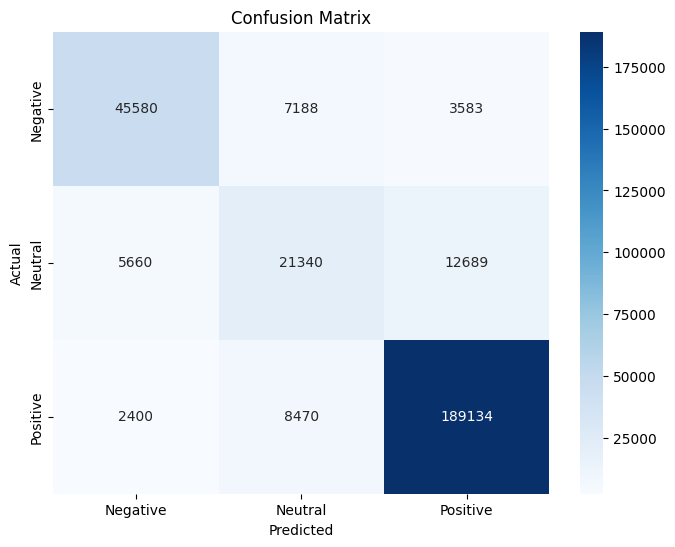

In [50]:
print("\nDetailed Classification Report:")
print(classification_report(test_scores_numerical, y_pred_classes))

plt.figure(figsize=(8,6))
cm = confusion_matrix(test_scores_numerical, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()